## Imports and global variables

In [1]:
import os
import re
import pandas as pd
import numpy as np
import torch

In [2]:
TIMESTAMPS_PATH = 'train/train/scene_timestamps'
FEATURES_PATH = 'train/train/features'
LABELS_PATH = 'train/train/labels'
SUBTITLES_PATH = 'train/train/subtitles'

TEST_TIMESTAMPS_PATH = 'test/test/scene_timestamps'
TEST_FEATURES_PATH = 'test/test/features'
TEST_SUBTITLES_PATH = 'test/test/subtitles'

In [3]:
# Check GPU available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Convert ass2srt

In [4]:
def ass_to_srt(ass_file, srt_file):
    with open(ass_file, 'r', encoding='utf-8') as ass:
        lines = ass.readlines()

    events_section = False
    subtitles = []

    for line in lines:
        if line.strip() == '[Events]':
            events_section = True
            continue

        if events_section and line.strip() and line[0] != ';':
            fields = line.split(',')
            if len(fields) >= 10:
                start_time = fields[1]
                end_time = fields[2]
                text = ','.join(fields[9:]).strip()
                text = re.sub(r'{.*?}', '', text)
                text = text.replace(r'\N', ' ')
                if start_time != ' Start' and end_time != ' End':
                    subtitles.append((start_time, end_time, text))

    with open(srt_file, 'w', encoding='utf-8') as srt:
        for i, subtitle in enumerate(subtitles, start=1):
            start_time, end_time, text = subtitle
            srt.write(f"{i}\n{start_time} --> {end_time}\n{text}\n\n")

In [5]:
ass_file_path = 'train/train/ass_files/tt0455824_australia.ass'
srt_file_path = "train/train/subtitles/tt0455824_australia.srt"

ass_to_srt(ass_file_path, srt_file_path)

## Load data

### Helper functions

In [6]:
def load_files(path):
    if os.path.exists(path):
        return os.listdir(path)
    else:
        print("PATH DOES NOT EXIST!")
        return []

In [7]:
def get_movie_name(file):
    return file[10:-15]

def get_movie_id(file):
    return file[:9]

In [8]:
def get_feature_file(file):
    return file.replace("_timestamps", "")

In [9]:
def prepare_csv(path, movie_name):
    df = pd.read_csv(path)
    df.rename(columns={"Unnamed: 0": "scene_id"}, inplace=True)
    df["movie"] = movie_name
    return df

In [10]:
def extract_movie_info(files):
    movie_ids, movies = [], []
    for file in files:
        movie_name = get_movie_name(file)
        movie_id = get_movie_id(file)
        movie_ids.append(movie_id)
        movies.append(movie_name)
    return movie_ids, movies

def prepare_dataframes(files, movies, path_func, data_func):
    dfs = []
    for idx, file in enumerate(files):
        path = path_func(file)
        df = data_func(path, movies[idx])
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def merge_dataframes(df1, df2):
    test_full_data = pd.merge(df1, df2, on=["scene_id", "movie"])
    test_full_data["end"] = test_full_data["start"] + test_full_data["s_dur"]
    return test_full_data

### Files

In [11]:
train_files = load_files(TIMESTAMPS_PATH)
# remove australia because australia subtitles are in diffrent format than everything else
# train_files.remove("tt0455824_australia_timestamps.csv")

test_files = load_files(TEST_TIMESTAMPS_PATH)

### Movies

In [12]:
train_movies_ids, train_movies = extract_movie_info(train_files)
test_movies_ids, test_movies = extract_movie_info(test_files)

### Timestamps

In [13]:
train_timestamps = prepare_dataframes(
    train_files,
    train_movies,
    lambda file: os.path.join(TIMESTAMPS_PATH, file), 
    prepare_csv
)

test_timestamps = prepare_dataframes(
    test_files,
    test_movies,
    lambda file: os.path.join(TEST_TIMESTAMPS_PATH, file), 
    prepare_csv
)

### Features

In [14]:
train_features = prepare_dataframes(
    train_files,
    train_movies,
    lambda file: os.path.join(FEATURES_PATH, get_feature_file(file)), 
    prepare_csv
)

test_features = prepare_dataframes(
    test_files,
    test_movies,
    lambda file: os.path.join(TEST_FEATURES_PATH, get_feature_file(file)), 
    prepare_csv
)

### Labels

In [15]:
dfs = []
for idx, file in enumerate(train_files):
    # print(feature_files[idx])
    labels_path = os.path.join(LABELS_PATH, get_feature_file(file))
    
    df = pd.read_csv(labels_path, keep_default_na=False)
    df.rename(
        columns={
            "Unnamed: 0": "scene_id",
            "0": "label"
        }, inplace=True
    )
    df["movie"] = train_movies[idx]
    
    dfs.append(df)

train_labels = pd.concat(dfs, ignore_index=True)
# print(train_labels.shape)
# train_labels.tail()

### Merge dataframes

In [16]:
train_merged = merge_dataframes(train_timestamps, train_features)
# additionaly merge labels to train data
train_full_data = pd.merge(train_merged, train_labels, on=["scene_id", "movie"], how="outer")
print(train_full_data.shape)

test_full_data = merge_dataframes(test_timestamps, test_features)
print(test_full_data.shape)

(3978, 12)
(2470, 11)


## Join Scenes with subtitles

In [17]:
import srt

### Helper runctions

In [18]:
train_movie_scenes_count = train_full_data.groupby('movie').count()['scene_id']
# print(train_movie_scenes_count)
test_movie_scenes_count = test_full_data.groupby('movie').count()['scene_id']

In [19]:
train_full_data

,scene_id,start,end,movie,s_dur,n_shots,ava_shot_dur,rel_id_loc,rel_t_loc,ava_char_score,is_prot_appear,label
0,0,0.000,218.718333,the lost weekend,218.718333,6,36.453056,0.000000,0.000000,1295.579078,1,Opening Image
1,1,218.760,240.740333,the lost weekend,21.980333,3,7.326778,0.008403,0.036189,1295.579078,1,Opening Image
2,2,240.782,282.574333,the lost weekend,41.792333,1,41.792333,0.016807,0.039832,1256.344447,1,Set-Up
3,3,282.616,313.521333,the lost weekend,30.905333,1,30.905333,0.025210,0.046752,1256.344447,1,Set-Up
4,4,313.563,367.033333,the lost weekend,53.470333,4,13.367583,0.033613,0.051871,1256.344447,1,Theme Stated
...,...,...,...,...,...,...,...,...,...,...,...,...
3973,220,6499.655,6574.354333,dallas buyers club,74.699333,16,4.668708,0.960699,0.926278,656.478716,1,Finale
3974,221,6574.396,6579.776333,dallas buyers club,5.380333,1,5.380333,0.965066,0.936929,372.108700,0,Finale
3975,224,6589.161,6623.987333,dallas buyers club,34.826333,6,5.804389,0.978166,0.939033,928.370357,1,Final Image
3976,226,6629.701,6682.462333,dallas buyers club,52.761333,19,2.776912,0.986900,0.944811,1076.267498,1,Final Image


In [20]:
problematic_movies = ["the ugly truth", "the social network", "the girl with the dragon tattoo"]

In [21]:
def convert_files_to_subtitles(files):
    return [file.replace('.csv', '.srt') for file in files]

def load_subtitles(paths, movies):
    movie_subtitles = {}
    for idx, movie_name in enumerate(movies):
        # print(movie_name)
        
        if movie_name == "pretty woman":
            with open(paths[idx], 'r', encoding='utf-16') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
        elif movie_name in problematic_movies:
            with open(paths[idx], 'r', encoding='utf-8', errors='replace') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
        else:
            with open(paths[idx], 'r', encoding='utf-8') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
                
    return movie_subtitles

def associate_scenes_with_subtitles(full_data, movie_subtitles):
    movies_scenes_subtitles = {}
    additional_data = []
    last_processed_subtitle_idx = 0
    missed_subtitles = 0

    for scene_idx, scene_row in full_data.iterrows():
        scene_start, scene_end = scene_row['start'], scene_row['end']
        scene_id, movie_name = scene_row['scene_id'], scene_row['movie']
        
        # Create new dictionary for every movie
        if movie_name not in movies_scenes_subtitles:
            movies_scenes_subtitles[movie_name] = {}
            last_processed_subtitle_idx = 0

        # Craete new dictionary for every scene within movie
        movies_scenes_subtitles[movie_name][scene_id] = []

        current_movie_subtitles = movie_subtitles[movie_name]
        sentence_count = 0
        for idx in range(last_processed_subtitle_idx, len(current_movie_subtitles)):
            sub = current_movie_subtitles[idx]
            sub_start, sub_end = sub.start.total_seconds(), sub.end.total_seconds()

            # Some subtitles start just before scene_start
            if scene_start <= (sub_start + 0.05) and scene_end >= sub_end:
                # Add subtitle content to the dictionary for the current scene
                movies_scenes_subtitles[movie_name][scene_id].append(sub.content)
                sentence_count += sub.content.count('.') + sub.content.count('!') + sub.content.count('?')
            elif scene_end < sub_end:
                last_processed_subtitle_idx = idx
                break
            else:
                missed_subtitles += 1
        
        additional_data.append({
            'movie': movie_name,
            'scene_id': scene_id,
            'sentence_count': sentence_count,
        })

    print(f"Ignored subtitltes: {missed_subtitles}")
    additional_df = pd.DataFrame(additional_data)
    return movies_scenes_subtitles, additional_df

In [22]:
def format_data(name, data):
    formatted_data = "{:.0f}".format(data)
    # print(f"{name}{formatted_data}")
    return name + formatted_data


def map_scene_location_to_category(x):
    scene_mapping = {
        (0, 1): "Opening",
        (2, 15): "Setup",
        (16, 19): "Debate",
        (20, 49): "Story",
        (50, 75): "BadGuys",
        (76, 89): "Ending",
        (90, 99): "Finale",
        (99, float('inf')): "FinalImage"
    }

    for percentage_range, category in scene_mapping.items():
        if percentage_range[0] <= x <= percentage_range[1]:
            return category

    return "InvalidValue"


def associate_scenes_with_subtitles_extra_info(full_data, movie_subtitles, movie_scenes_count):
    movies_scenes_subtitles = {}
    last_processed_subtitle_idx = 0
    missed_subtitles = 0

    for scene_idx, scene_row in full_data.iterrows():
        scene_start, scene_end = scene_row['start'], scene_row['end']
        scene_id, movie_name = scene_row['scene_id'], scene_row['movie']
        scene_location, time_location = scene_row['rel_id_loc'], scene_row['rel_t_loc'] 	
        prot_appear = scene_row['is_prot_appear']
        scene_count = movie_scenes_count[movie_name]

        movie_name_without_spaces = movie_name.replace(" ", "")
        category = map_scene_location_to_category(int(scene_location * 100))
        
        scene_location_result = format_data("SceneLocation", scene_location * 100)
        time_location_result = format_data("TimeLocation", time_location * 100)
        category_result = f"category{category}"
        movie_name_result = f"MovieName{movie_name_without_spaces}"
        scene_start_result = format_data("SceneStart", scene_start)
        scene_end_result = format_data("SceneEnd", scene_end)
        prot_appear_result = format_data("ProtAppear", prot_appear)
        scene_count_result = format_data("SceneCount", scene_count)
        
        # Create new dictionary for every movie
        if movie_name not in movies_scenes_subtitles:
            movies_scenes_subtitles[movie_name] = {}
            last_processed_subtitle_idx = 0

        # Craete new dictionary for every scene within movie
        movies_scenes_subtitles[movie_name][scene_id] = []
        movies_scenes_subtitles[movie_name][scene_id].append(scene_location_result)
        movies_scenes_subtitles[movie_name][scene_id].append(time_location_result)
        movies_scenes_subtitles[movie_name][scene_id].append(category_result)
        movies_scenes_subtitles[movie_name][scene_id].append(movie_name_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_start_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_end_result)
        movies_scenes_subtitles[movie_name][scene_id].append(prot_appear_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_count_result)

        current_movie_subtitles = movie_subtitles[movie_name]
        for idx in range(last_processed_subtitle_idx, len(current_movie_subtitles)):
            sub = current_movie_subtitles[idx]
            sub_start, sub_end = sub.start.total_seconds(), sub.end.total_seconds()

            # Some subtitles start just before scene_start
            if scene_start <= (sub_start + 0.05) and scene_end >= sub_end:
                # Add subtitle content to the dictionary for the current scene
                movies_scenes_subtitles[movie_name][scene_id].append(sub.content)
            elif scene_end < sub_end:
                last_processed_subtitle_idx = idx
                break
            else:
                missed_subtitles += 1
        
    print(f"Ignored subtitltes: {missed_subtitles}")
    return movies_scenes_subtitles

### Get subtitle files

In [23]:
train_features_files = load_files(FEATURES_PATH)
# remove australia because australia subtitles are in diffrent format than everything else
# train_features_files.remove('tt0455824_australia.csv')
test_features_files = load_files(TEST_FEATURES_PATH)

train_subtitles_files = convert_files_to_subtitles(train_features_files)
train_subtitle_paths = [os.path.join(SUBTITLES_PATH, subtitle_file) for subtitle_file in train_subtitles_files]

test_subtitles_files = convert_files_to_subtitles(test_features_files)
test_subtitle_paths = [os.path.join(TEST_SUBTITLES_PATH, subtitle_file) for subtitle_file in test_subtitles_files]

### Load subtitles 

In [24]:
train_movie_subtitles = load_subtitles(train_subtitle_paths, train_movies)
test_movie_subtitles = load_subtitles(test_subtitle_paths, test_movies)

### Associate Scenes with subtitles

In [25]:
train_movies_scenes_subtitles, additional_train_data = associate_scenes_with_subtitles(train_full_data, train_movie_subtitles)
test_movies_scenes_subtitles, additional_test_data = associate_scenes_with_subtitles(test_full_data, test_movie_subtitles)

Ignored subtitltes: 3204
Ignored subtitltes: 3165


## Subtitles cleaning and combining

### Helper functions

In [26]:
unique_labels = train_full_data['label'].unique()
label_to_int_mapping = {label: i for i, label in enumerate(unique_labels)}
int_to_label_mapping = {i: label for label, i in label_to_int_mapping.items()}

def map_label_to_int(label):
    return label_to_int_mapping[label]


def map_label_from_int(label):
    return int_to_label_mapping[label] 

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# We can lemmetize and remove_stopwords in one function if it takes too long: 
# [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
def lemmetize(text):
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return ' '.join(filtered_words)


def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


def preprocess_function(examples):
    examples["text"] = [remove_stopwords(text) for text in examples["text"]]
    tokenized_text = tokenizer(examples["text"], truncation=True)
    
    return tokenized_text

In [28]:
def clean_subtitles(movies_scenes_subtitles):
    for movie_name, scenes in movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            cleaned_subtitles = []
            for subtitle in subtitles:
                # Remove new line characters
                cleaned_subtitle = subtitle.replace('\n', ' ').strip()
                cleaned_subtitle = re.sub(r'<.*?>', '', cleaned_subtitle)
                cleaned_subtitle = re.sub(r'♪', '', cleaned_subtitle)
                cleaned_subtitles.append(cleaned_subtitle)
            
            combined_text = " ".join(cleaned_subtitles)
            movies_scenes_subtitles[movie_name][scene_id] = combined_text
            
    return movies_scenes_subtitles


def clean_subtitles_only_words(movies_scenes_subtitles):
    for movie_name, scenes in movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            cleaned_subtitles = []
            for subtitle in subtitles:
                cleaned_subtitle = subtitle.replace('\n', ' ').strip()
                cleaned_subtitle = re.sub(r'<.*?>', '', cleaned_subtitle)
                cleaned_subtitle = re.sub(r'[^a-zA-Z0-9\s\']', '', cleaned_subtitle)
                cleaned_subtitles.append(cleaned_subtitle)
            
            combined_text = " ".join(cleaned_subtitles)
            movies_scenes_subtitles[movie_name][scene_id] = combined_text
            
    return movies_scenes_subtitles


def transform_subtitles(subtitles, df):
    transformed_subtitles = []
    for movie_name, scenes in subtitles.items():
        for scene_id, text in scenes.items():
            # Get the label from train_full_data based on movie and scene_id
            label = df[(df['movie'] == movie_name) & (df['scene_id'] == scene_id)]['label'].values[0]
            label = map_label_to_int(label)
            
            result = {'text': text, 'label': label}
            transformed_subtitles.append(result)
    
    return transformed_subtitles


def transform_subtitles_no_labels(subtitles):
    transformed_subtitles = []
    for movie_name, scenes in subtitles.items():
        for scene_id, text in scenes.items():
            result = {'text': text}
            transformed_subtitles.append(result)
    
    return transformed_subtitles


# def transform_subtitles_tf_idf(subtitles):
#     transformed_subtitles = ""
#     for movie_name, scenes in subtitles.items():
#         for scene_id, text in scenes.items():
#             transformed_subtitles += text
    
#     return transformed_subtitles
    

def print_head_transformed_subtitles(subtiltes):
    for i in range(min(5, len(subtiltes))):
        print(subtiltes[i])

In [29]:
clean_train_movies_scenes_subtitles = clean_subtitles_only_words(train_movies_scenes_subtitles)
clean_train_movies_scenes_subtitles['four weddings and a funeral'][3]

" Although I can't dismiss   The memory of her kiss   I guess he's not for me "

In [30]:
clean_test_movies_scenes_subtitles = clean_subtitles_only_words(test_movies_scenes_subtitles)
clean_test_movies_scenes_subtitles['gone girl'][3]

"His majesty prefers not to be moistened I got you a present Oh I hated this game You loved it You loved it Thank you I'll add it to the collection Can you pour me a bourbon SIGHS What's up Jitters BREATHES DEEPLY Well if you're not going to talk I'm gonna have to fill the silence with another excruciating story by Margo Dunne I could tell you about my recent customer service experience changing Internet service providers I like that one Or how about the time I saw that woman who looked exactly like my friend Monica But it wasn't Monica It was a total stranger Who was also named Monica Made it kind of interesting It's great I'm just having a bad day Amy It's our anniversary Five years Five That came fast And furious"

In [31]:
clean_train_movies_scenes_subtitles['australia'][3]

'FarangSiam thanks you Have Fun'

## Add additionaly data

In [32]:
train_full_data = pd.merge(train_full_data, additional_train_data, on=["movie", "scene_id"])
test_full_data = pd.merge(test_full_data, additional_test_data, on=["movie", "scene_id"])

## Random Forest (First Model)

### TF-IDF

In [33]:
train_transformed_subtitles = clean_train_movies_scenes_subtitles
for movie_name, scenes in clean_train_movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            tokens = nltk.word_tokenize(subtitles)
            lower_words = [word.lower() for word in tokens]
            no_stopwords = [word for word in lower_words if word not in stopwords.words('english')]
            no_alpha = [word for word in no_stopwords if word.isalpha()]
            lemm_text = [lemmatizer.lemmatize(word) for word in no_alpha]
            subtitles = lemm_text

            train_transformed_subtitles[movie_name][scene_id] = subtitles

In [54]:
test_transformed_subtitles = clean_test_movies_scenes_subtitles
for movie_name, scenes in clean_test_movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            tokens = nltk.word_tokenize(subtitles)
            lower_words = [word.lower() for word in tokens]
            no_stopwords = [word for word in lower_words if word not in stopwords.words('english')]
            no_alpha = [word for word in no_stopwords if word.isalpha()]
            lemm_text = [lemmatizer.lemmatize(word) for word in no_alpha]
            subtitles = lemm_text

            test_transformed_subtitles[movie_name][scene_id] = subtitles

In [34]:
all_subtitles = " ".join([word for scenes in train_transformed_subtitles.values() for subtitles in scenes.values() for word in subtitles])

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import strip_accents_ascii

def tf_idf(subtitles):
    if subtitles == "":
        return {}
    
    tfidf_vectorizer = TfidfVectorizer(strip_accents=strip_accents_ascii)
    tfidf_matrix = tfidf_vectorizer.fit_transform([subtitles])
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_values = tfidf_matrix.toarray()[0]
    
    tfidf_dict = dict(zip(feature_names, tfidf_values))

    return tfidf_dict

In [36]:
all_tfidf_dict = tf_idf(all_subtitles)

#### Get top x words based on tf-idf

In [37]:
def get_top_words(tfidf_dict, n):
    top_n = n
    sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    top_words = [word for word, _ in sorted_tfidf]
    return top_words

top_words = get_top_words(all_tfidf_dict, 10)
# top_tfidf_values = [tfidf for _, tfidf in sorted_tfidf]

# top_words_dict = dict(zip(top_words, top_tfidf_values))

#### Tf-idf for each scene

In [38]:
tf_idf_movies = {}
for movie_name, scenes in train_transformed_subtitles.items():
    tf_idf_movies[movie_name] = {}
    for scene_id, subtitles in scenes.items():
        tf_idf_scene = []
        
        tfidf_scene_dict = tf_idf(' '.join(subtitles))
        scene_tfidf_top_words = {word: 0.0 for word in top_words}
    
        for word in top_words:
            if word in tfidf_scene_dict:
                scene_tfidf_top_words[word] = tfidf_scene_dict[word]

        tf_idf_scene.append(scene_tfidf_top_words)
        tf_idf_movies[movie_name][scene_id] = tf_idf_scene

In [55]:
test_tf_idf_movies = {}
for movie_name, scenes in test_transformed_subtitles.items():
    test_tf_idf_movies[movie_name] = {}
    for scene_id, subtitles in scenes.items():
        tf_idf_scene = []
        
        tfidf_scene_dict = tf_idf(' '.join(subtitles))
        scene_tfidf_top_words = {word: 0.0 for word in top_words}
    
        for word in top_words:
            if word in tfidf_scene_dict:
                scene_tfidf_top_words[word] = tfidf_scene_dict[word]

        tf_idf_scene.append(scene_tfidf_top_words)
        test_tf_idf_movies[movie_name][scene_id] = tf_idf_scene

#### Prepare df with top_words 

In [39]:
prefix = "word_"
prefixed_top_words = [prefix + word for word in top_words]

In [40]:
all_dataframes = []

for movie_name, scenes in train_transformed_subtitles.items():
    for scene_id, subtitles in scenes.items():
        scene_data = tf_idf_movies[movie_name][scene_id]
        new_df = pd.DataFrame(scene_data).add_prefix(prefix) 
        new_df['movie'] = movie_name
        new_df['scene_id'] = scene_id

        all_dataframes.append(new_df)

final_tf_idf_df = pd.concat(all_dataframes, ignore_index=True)
final_tf_idf_df.head()

,word_know,word_get,word_like,word_right,word_got,word_yeah,word_go,word_oh,word_na,word_well,movie,scene_id
0,0.196116,0.196116,0.000,0.098058,0.000000,0.098058,0.000000,0.000000,0.196116,0.098058,the lost weekend,0
1,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353553,the lost weekend,1
2,0.127000,0.127000,0.127,0.000000,0.000000,0.000000,0.000000,0.127000,0.000000,0.000000,the lost weekend,2
3,0.118678,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118678,the lost weekend,3
4,0.000000,0.000000,0.000,0.090909,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,the lost weekend,4


In [57]:
all_dataframes = []

for movie_name, scenes in test_transformed_subtitles.items():
    for scene_id, subtitles in scenes.items():
        scene_data = test_tf_idf_movies[movie_name][scene_id]
        new_df = pd.DataFrame(scene_data).add_prefix(prefix) 
        new_df['movie'] = movie_name
        new_df['scene_id'] = scene_id

        all_dataframes.append(new_df)

final_tf_idf_df = pd.concat(all_dataframes, ignore_index=True)
final_tf_idf_df.head()

,word_know,word_get,word_like,word_right,word_got,word_yeah,word_go,word_oh,word_na,word_well,movie,scene_id
0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,marley and me,1
1,0.083918,0.251754,0.000000,0.00000,0.000000,0.000000,0.0,0.083918,0.083918,0.083918,marley and me,2
2,0.145865,0.437595,0.145865,0.29173,0.291730,0.145865,0.0,0.145865,0.000000,0.145865,marley and me,4
3,0.332182,0.249136,0.166091,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.166091,marley and me,6
4,0.000000,0.000000,0.116248,0.00000,0.464991,0.116248,0.0,0.116248,0.000000,0.000000,marley and me,7


In [41]:
merged_train_data = pd.merge(train_full_data, final_tf_idf_df, on=['scene_id', 'movie'], how='left')
merged_train_data.fillna(0, inplace=True)
merged_train_data.head()

,scene_id,start,end,movie,s_dur,n_shots,ava_shot_dur,rel_id_loc,rel_t_loc,ava_char_score,...,word_know,word_get,word_like,word_right,word_got,word_yeah,word_go,word_oh,word_na,word_well
0,0,0.000,218.718333,the lost weekend,218.718333,6,36.453056,0.000000,0.000000,1295.579078,...,0.196116,0.196116,0.000,0.098058,0.000000,0.098058,0.000000,0.000000,0.196116,0.098058
1,1,218.760,240.740333,the lost weekend,21.980333,3,7.326778,0.008403,0.036189,1295.579078,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353553
2,2,240.782,282.574333,the lost weekend,41.792333,1,41.792333,0.016807,0.039832,1256.344447,...,0.127000,0.127000,0.127,0.000000,0.000000,0.000000,0.000000,0.127000,0.000000,0.000000
3,3,282.616,313.521333,the lost weekend,30.905333,1,30.905333,0.025210,0.046752,1256.344447,...,0.118678,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118678
4,4,313.563,367.033333,the lost weekend,53.470333,4,13.367583,0.033613,0.051871,1256.344447,...,0.000000,0.000000,0.000,0.090909,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000


In [58]:
merged_test_data = pd.merge(test_full_data, final_tf_idf_df, on=['scene_id', 'movie'], how='left')
merged_test_data.fillna(0, inplace=True)
merged_test_data.head()

,scene_id,start,end,movie,s_dur,n_shots,ava_shot_dur,rel_id_loc,rel_t_loc,ava_char_score,...,word_know,word_get,word_like,word_right,word_got,word_yeah,word_go,word_oh,word_na,word_well
0,1,51.343,83.583333,marley and me,32.240333,11,2.930939,0.008333,0.007405,2569.410356,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,2,83.625,158.784333,marley and me,75.159333,16,4.697458,0.016667,0.012060,2339.158052,...,0.083918,0.251754,0.000000,0.00000,0.000000,0.000000,0.0,0.083918,0.083918,0.083918
2,4,239.698,264.473333,marley and me,24.775333,7,3.539333,0.033333,0.034568,2339.158052,...,0.145865,0.437595,0.145865,0.29173,0.291730,0.145865,0.0,0.145865,0.000000,0.145865
3,6,271.021,349.474333,marley and me,78.453333,23,3.411014,0.050000,0.039086,1276.551574,...,0.332182,0.249136,0.166091,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.166091
4,7,349.516,385.802333,marley and me,36.286333,10,3.628633,0.058333,0.050406,2339.158052,...,0.000000,0.000000,0.116248,0.00000,0.464991,0.116248,0.0,0.116248,0.000000,0.000000


### Tuning hyperparameters

In [59]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

X = merged_train_data[['rel_id_loc', 'rel_t_loc', 'ava_char_score', 'is_prot_appear', 'word_know', 'word_get', 'word_like', 'word_right', 'word_got', 'word_yeah', 'word_go', 'word_oh', 'word_na', 'word_well']]
y = merged_train_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.3, stratify=y)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500, 1000],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 50, 70, 100],
    'min_samples_leaf': [1, 2, 5, 10, 15, 25],
    'max_depth': [1, 2, 5, 10, 20, 50, 75]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=23), param_distributions=param_dist, n_iter=10, cv=5, random_state=23, n_jobs=-1)
random_search.fit(X, y)
# random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_depth': 10}


### Cross-Validation

In [60]:
best_params = random_search.best_params_
model = RandomForestClassifier(**best_params, random_state=23)
model.fit(X, y)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# scores = cross_val_score(model, X_train, y_train, cv=5)
# print(f"Scores: {scores}")
# print(f"Mean Accuracy from cross-validation on training set: {np.mean(scores)}")

RandomForestClassifier(max_depth=10, min_samples_leaf=15, min_samples_split=10,
                       n_estimators=200, random_state=23)

### Scores

In [49]:
_, levels = pd.factorize(merged_train_data['label'])
print(classification_report(y_test,y_pred,target_names=levels))

accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")

                        precision    recall  f1-score   support

         Opening Image       0.00      0.00      0.00        21
                Set-Up       0.38      0.69      0.49       137
          Theme Stated       0.41      0.70      0.51       125
              Catalyst       0.00      0.00      0.00        28
                Debate       0.83      0.20      0.32        25
                  None       0.00      0.00      0.00        23
        Break into Two       0.25      0.27      0.26        52
               B Story       0.47      0.47      0.47        73
              Midpoint       0.83      0.58      0.68        26
     Bad Guys Close In       0.76      0.90      0.83       195
           All Is Lost       0.45      0.14      0.21       111
Dark Night of the Soul       1.00      0.03      0.06        31
      Break into Three       0.33      0.20      0.25       162
                Finale       0.86      0.60      0.71        20
           Final Image       0.68      

c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [50]:
# Assuming 'model', 'X', and 'y' are already defined
predicted = cross_val_predict(model, X, y, cv=5)
conf_matrix = confusion_matrix(y, predicted)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   2  37   0   0   0   6   0   0  10   0   0  15   0   0   0]
 [  0 265  61   0   0   0   1  34   0   5  49   0  41   0   2   0]
 [  0  41 278   0   0   0  19   0   0   8  23   1  48   0   0   0]
 [  0   0  21   0   0   0  17   0   0  38   0   0  17   0   0   0]
 [  0  34   0   0   2   0   0  28   0   0   7   0   8   0   3   0]
 [  0  17   0   0   0   0   0  17   0   0   0   0   0   0  42   0]
 [  0   0  50   0   0   0  23   0   0  42   0   0  59   0   0   0]
 [  0  62   0   0   1   0   0 105   0   0   3   0  11   0  60   0]
 [  0   0   0   0   0   0   0   0  56  30   0   0   0   0   0   0]
 [  0   0  10   0   0   0  11   0  13 581   0   0  34   0   0   0]
 [  0 178 102   0   1   0  13  14   0  11  22   0  28   0   1   0]
 [  0  40  43   0   0   0   3   0   0   0  11   0   8   0   0   0]
 [  0 115 132   0   1   0  37  36   1  77  19   1  62   1  57   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  40  26   0]
 [  0  15   0   0   0   0   0  40   0   0   

<Axes: >

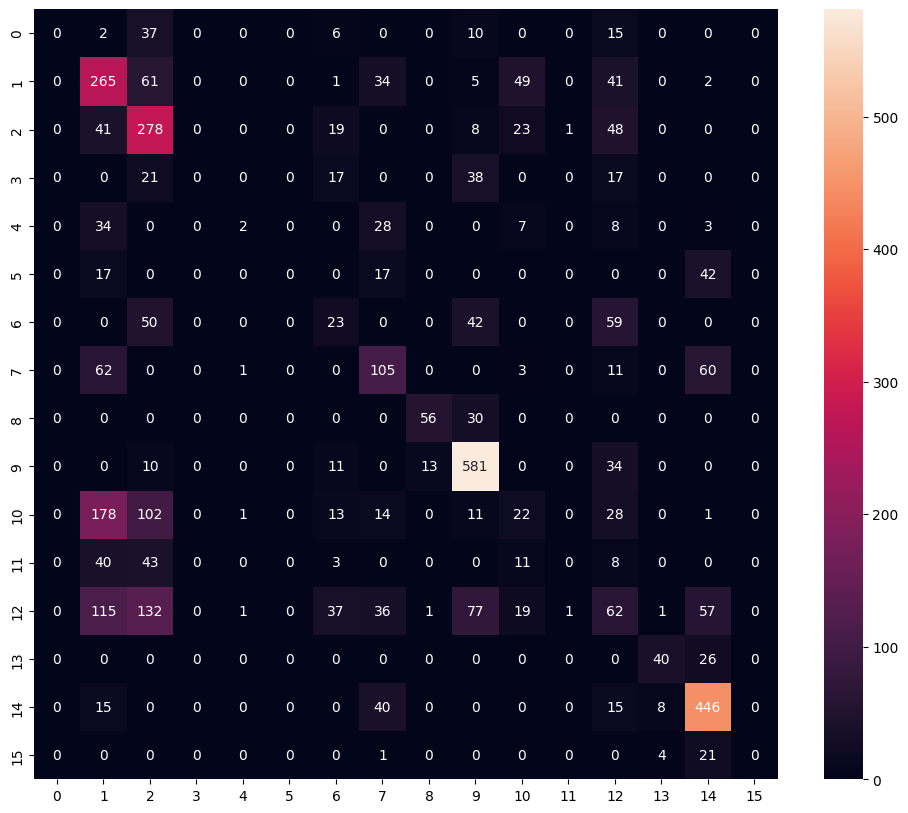

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_matrix, fmt='g', ax=ax, annot=True)

### Feature importances

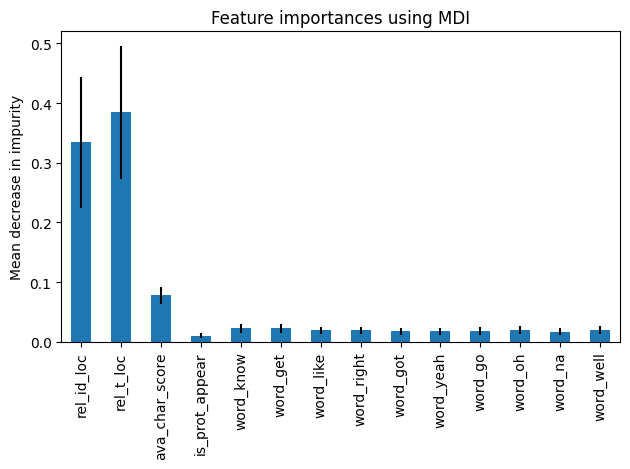

In [52]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Predict for real test data

In [65]:
X = merged_test_data[['rel_id_loc', 'rel_t_loc', 'ava_char_score', 'is_prot_appear', 'word_know', 'word_get', 'word_like',
                      'word_right', 'word_got', 'word_yeah', 'word_go', 'word_oh', 'word_na', 'word_well']]

y_pred_labels = model.predict(X)

In [66]:
print(y_pred_labels.shape)
print(test_full_data.shape)

(2470,)
(2470, 12)


## XGBoost (Second Model)

In [79]:
from collections import Counter
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# X = train_full_data[['s_dur','n_shots','ava_shot_dur','rel_id_loc','rel_t_loc','ava_char_score','is_prot_appear','sentence_count']]
X = merged_train_data.drop(['start', 'end', 'movie', 'scene_id', 'label'], axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_train_data['label'])


X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=23, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=23, test_size=0.5, stratify=y_temp)

test_class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
test_class_weights_dict = dict(zip(np.unique(y_train), test_class_weights))
test_sample_weight = np.array([test_class_weights_dict[class_label] for class_label in y_train])

param_dist = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5, 2.0],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'gamma': [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'early_stopping_rounds': [2, 4, 6, 8, 10, 12, 14]
}

xgb = XGBClassifier(random_state=23)

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=5, random_state=23, n_jobs=-1)
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, sample_weight=test_sample_weight)

print("Best parameters:", random_search.best_params_)

[0]	validation_0-mlogloss:2.70574
[1]	validation_0-mlogloss:2.64618
[2]	validation_0-mlogloss:2.58090
[3]	validation_0-mlogloss:2.53170
[4]	validation_0-mlogloss:2.47251
[5]	validation_0-mlogloss:2.42652
[6]	validation_0-mlogloss:2.38769
[7]	validation_0-mlogloss:2.33857
[8]	validation_0-mlogloss:2.29354
[9]	validation_0-mlogloss:2.25081
[10]	validation_0-mlogloss:2.21519
[11]	validation_0-mlogloss:2.17938
[12]	validation_0-mlogloss:2.14864
[13]	validation_0-mlogloss:2.12112
[14]	validation_0-mlogloss:2.09181
[15]	validation_0-mlogloss:2.07052
[16]	validation_0-mlogloss:2.04688
[17]	validation_0-mlogloss:2.02278
[18]	validation_0-mlogloss:2.00049
[19]	validation_0-mlogloss:1.98102
[20]	validation_0-mlogloss:1.96263
[21]	validation_0-mlogloss:1.94591
[22]	validation_0-mlogloss:1.92643
[23]	validation_0-mlogloss:1.90474
[24]	validation_0-mlogloss:1.88548
[25]	validation_0-mlogloss:1.86923
[26]	validation_0-mlogloss:1.85324
[27]	validation_0-mlogloss:1.83520
[28]	validation_0-mlogloss:1.8

In [80]:
best_params = random_search.best_params_
model = XGBClassifier(**best_params, random_state=23)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, sample_weight=test_sample_weight)

[0]	validation_0-mlogloss:2.70574
[1]	validation_0-mlogloss:2.64618
[2]	validation_0-mlogloss:2.58090
[3]	validation_0-mlogloss:2.53170
[4]	validation_0-mlogloss:2.47251
[5]	validation_0-mlogloss:2.42652
[6]	validation_0-mlogloss:2.38769
[7]	validation_0-mlogloss:2.33857
[8]	validation_0-mlogloss:2.29354
[9]	validation_0-mlogloss:2.25081
[10]	validation_0-mlogloss:2.21519
[11]	validation_0-mlogloss:2.17938
[12]	validation_0-mlogloss:2.14864
[13]	validation_0-mlogloss:2.12112
[14]	validation_0-mlogloss:2.09181
[15]	validation_0-mlogloss:2.07052
[16]	validation_0-mlogloss:2.04688
[17]	validation_0-mlogloss:2.02278
[18]	validation_0-mlogloss:2.00049
[19]	validation_0-mlogloss:1.98102
[20]	validation_0-mlogloss:1.96263
[21]	validation_0-mlogloss:1.94591
[22]	validation_0-mlogloss:1.92643
[23]	validation_0-mlogloss:1.90474
[24]	validation_0-mlogloss:1.88548
[25]	validation_0-mlogloss:1.86923
[26]	validation_0-mlogloss:1.85324
[27]	validation_0-mlogloss:1.83520
[28]	validation_0-mlogloss:1.8

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=6,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [81]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.5309882747068677
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.48      0.64      0.55        69
           2       0.46      0.56      0.50        63
           3       0.14      0.14      0.14        14
           4       0.38      0.42      0.40        12
           5       0.00      0.00      0.00        12
           6       0.20      0.38      0.26        26
           7       0.57      0.58      0.58        36
           8       0.79      0.85      0.81        13
           9       0.83      0.80      0.82        97
          10       0.33      0.24      0.27        55
          11       0.18      0.25      0.21        16
          12       0.45      0.22      0.30        81
          13       0.73      0.80      0.76        10
          14       0.80      0.85      0.83        78
          15       0.67      0.50      0.57         4

    accuracy                           0.53       


Confusion Matrix:


<Axes: >

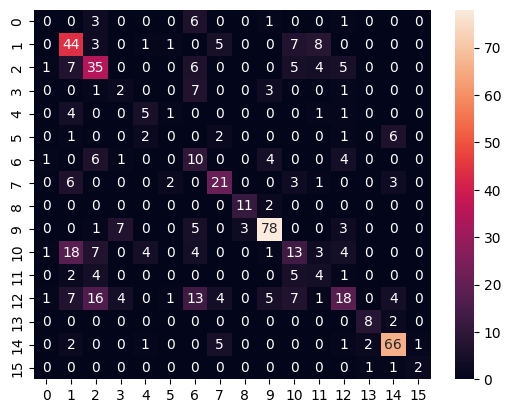

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='g')

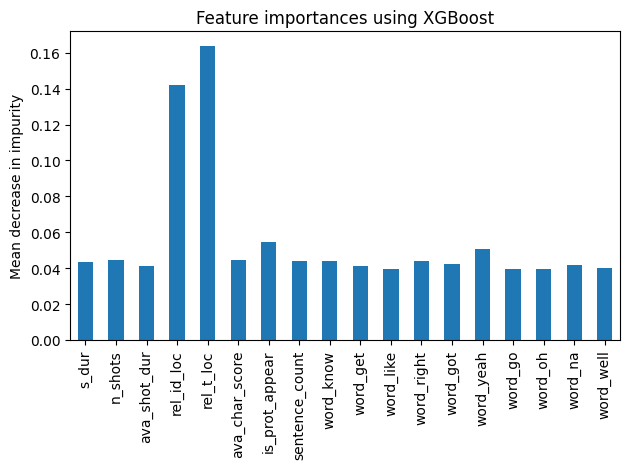

In [83]:
importances = model.feature_importances_
feature_names = X.columns
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using XGBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [85]:
X = merged_test_data.drop(['start', 'end', 'movie', 'scene_id'], axis=1)

y_pred = model.predict(X)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(y_pred_labels.shape)
print(test_full_data.shape)

(2470,)
(2470, 12)


## Text classification using BERT (Third Model)

### Helper functions

In [ ]:
train_subtitles = associate_scenes_with_subtitles_extra_info(train_full_data, train_movie_subtitles, train_movie_scenes_count)
clean_train_subtitles = clean_subtitles_only_words(train_subtitles)
train_transformed_subtitles = transform_subtitles(clean_train_subtitles, train_full_data)

In [ ]:
# train_transformed_subtitles

In [ ]:
validation_subtitles = associate_scenes_with_subtitles_extra_info(test_full_data, test_movie_subtitles, test_movie_scenes_count)
clean_validation_subtitles = clean_subtitles_only_words(validation_subtitles)
validation_transformed_subtitles = transform_subtitles_no_labels(clean_validation_subtitles)

In [ ]:
from sklearn.model_selection import train_test_split

# Extract 'text' and 'label' from each dictionary
texts = [item['text'] for item in train_transformed_subtitles]
labels = [item['label'] for item in train_transformed_subtitles]

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)

# # Create training and testing datasets
train_data = [{'text': text, 'label': label} for text, label in zip(train_texts, train_labels)]
test_data = [{'text': text, 'label': label} for text, label in zip(test_texts, test_labels)]

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)
validation_dataset = Dataset.from_list(validation_transformed_subtitles)

print(train_dataset)
print(test_dataset)
print(validation_dataset)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer

def choose_model(name):
    if name == "distilbert": 
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16)
    elif name == "bert":
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=16)
    elif name == "roberta":
        tokenizer = AutoTokenizer.from_pretrained("roberta-base")
        model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=16)
    elif name == "roberta-large":
        tokenizer = AutoTokenizer.from_pretrained("roberta-large")
        model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=16)
    else:
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16)

    return model, tokenizer

model, tokenizer = choose_model("roberta-large")

In [ ]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
tokenized_test_dataset

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=18,
    weight_decay=0.01,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_validation_dataset)

In [ ]:
predicted_probabilities = predictions.predictions
predicted_label_ids = np.argmax(predicted_probabilities, axis=-1)

label_predictions = [map_label_from_int(label) for label in predicted_label_ids]
print(f"first 10 predictions: {label_predictions[:10]} \nlast 10 predictions: {label_predictions[-10:]}")

## Result data

In [86]:
result_df = pd.DataFrame(columns=['Id', 'Label'])

def fill_result_df(full_data, movies, movies_ids, predictions):
    for idx, scene in full_data.iterrows():
        movie_name = scene['movie']
        movie_index = movies.index(movie_name)
        movie_id = movies_ids[movie_index]
        scene_id = scene['scene_id']
        movie_scene_id = f"{movie_id}_{scene_id}"

        pred_label = predictions[idx]
        result_df.loc[idx] = [movie_scene_id, pred_label]

In [87]:
# First model (RF)  & Second model (XGBoost)
fill_result_df(test_full_data, test_movies, test_movies_ids, y_pred_labels)

# Third model (Bert)
#fill_result_df(test_full_data, test_movies, test_movies_ids, label_predictions)


result_df.head(1)

,Id,Label
0,tt0822832_1,Opening Image


In [88]:
result_df.to_csv('output_xgb_tfidf.csv', index=False)

## Save model

In [ ]:
from transformers import BertConfig

folder_name = "models"

def save_model(model, tokenizer, name):
    model_folder_path = f"./{folder_name}/{name}" 
    model.save_model(model_folder_path)
    tokenizer.save_pretrained(model_folder_path)
    config = BertConfig.from_pretrained(model_folder_path)
    config.save_pretrained(model_folder_path)
    
save_model(trainer, tokenizer, "model_reoberta_18")

## Clean memory

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

## Save combined clean data in file

In [ ]:
output_file_path = "output_combined_file.txt"  # Set your desired output file

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for movie, scenes in clean_train_movies_scenes_subtitles.items():
        output_file.write(f"======= {movie} =========\n\n")
        output_file.write(str(scenes))

print("Combined text file saved successfully.")


In [ ]:
output_file_path = "output_combined_file2.txt"  # Set your desired output file

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for movie, scenes in clean_train_subtitles.items():
        output_file.write(f"======= {movie} =========\n\n")
        output_file.write(str(scenes))

print("Combined text file saved successfully.")


## Models Voting

In [92]:
from collections import Counter

def merge_csv_files(folder_path, output_file, file_accuracies):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f in file_accuracies]
    id_labels = {}

    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        current_df = pd.read_csv(file_path, keep_default_na=False)

        weight = file_accuracies.get(csv_file, 1) if file_accuracies else 1

        for _, row in current_df.iterrows():
            current_id = row['Id']
            current_label = row['Label']

            if current_id not in id_labels:
                id_labels[current_id] = {'labels': Counter()}

            id_labels[current_id]['labels'][current_label] += 1 * weight

    merged_data = {'Id': [], 'Label': []}
    for current_id, labels in id_labels.items():
        if current_id == 'tt0822832_84':
            print(current_id, labels)
        most_common_label = get_most_common_label(labels)

        merged_data['Id'].append(current_id)
        merged_data['Label'].append(most_common_label)

    merged_df = pd.DataFrame(merged_data)
    merged_df.to_csv(output_file, index=False)

def get_most_common_label(data):
    label_counts = data['labels']
    most_common_label = max(label_counts, key=label_counts.get)
    return most_common_label

In [95]:
folder_path = 'models_voting/'
output_file = 'output_voting.csv'

file_accuracies = {'output_bert_5.csv': 0.47035, 'output_bert_10.csv': 0.47503, 'output_bert_15.csv': 0.47971, 'output_roberta_12.csv': 0.47035, 
                   'output_roberta_15.csv': 0.48517, 'output_random_forest.csv': 0.48439, 'output_distilbert_9.csv': 0.46801}

best_result_acc = {'output_bert_5.csv': 0.47035, 'output_bert_10.csv': 0.47503, 'output_bert_15.csv': 0.47971, 'output_bert_30.csv': 0.44383,
                   'output_roberta_large_12.csv': 0.43837, 'output_roberta_15.csv': 0.48517}

merge_csv_files(folder_path, output_file, best_result_acc)

tt0822832_84 {'labels': Counter({'None': 1.43055, 'Dark Night of the Soul': 1.36191})}
